# Определение возраста покупателей

**Описание проекта:**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Задача:**

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.


**Ход проекта:**

- Проведите исследовательский анализ набора фотографий.
- Подготовьте данные к обучению.
- Обучите нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# настройка среды для работы
# зададим формат отображения вещественных чисел в Pandas
pd.set_option('display.float_format', '{:,.3f}'.format)

# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

# Сброс ограничений на число столбцов
pd.set_option('display.max_rows', None)

# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

In [3]:
labels = None

try:
    # Пытаемся загрузить файл
    labels = pd.read_csv(path + 'labels.csv')
except FileNotFoundError:
    # Обрабатываем исключение, если файл не найден
    print(f"Файл {path} не найден.")
except Exception as e:
    # Обрабатываем другие возможные ошибки
    print(f"Ошибка чтения файла {path}: {e}")
else:
    # Выполняем, если ошибок
    print(f"Файл {path} успешно загружен.")
finally:
    # Выполняем в любом случае, независимо от наличия ошибок
    if labels is None:
        print('Файл не загружен!')
    else:
        print('Загрузка завершена.')

Файл /datasets/faces/ успешно загружен.
Загрузка завершена.


In [4]:
def get_info(data):

    if data is None:
        print("Датасет пуст (None).")
        return

    try:
        print("Первые 5 строк:")
        display(data.head())

        print("\nОбщая информация:")
        data.info()

        print("\nОсновные статистики:")
        display(data.describe())

        print("\nКоличество явных дубликатов:", data.duplicated().sum())

        print("\nКоличество пропусков:")
        print(data.isna().sum())

    except Exception as e:
        print(f"Ошибка при выводе информации: {e}")

In [5]:
get_info(labels)

Первые 5 строк:


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB

Основные статистики:


,real_age
count,"7,591.000"
mean,31.201
std,17.145
min,1.000
25%,20.000
50%,29.000
75%,41.000
max,100.000



Количество явных дубликатов: 0

Количество пропусков:
file_name    0
real_age     0
dtype: int64


- В датасете 7591 фотографий,
- пропусков и дубликатов нет.

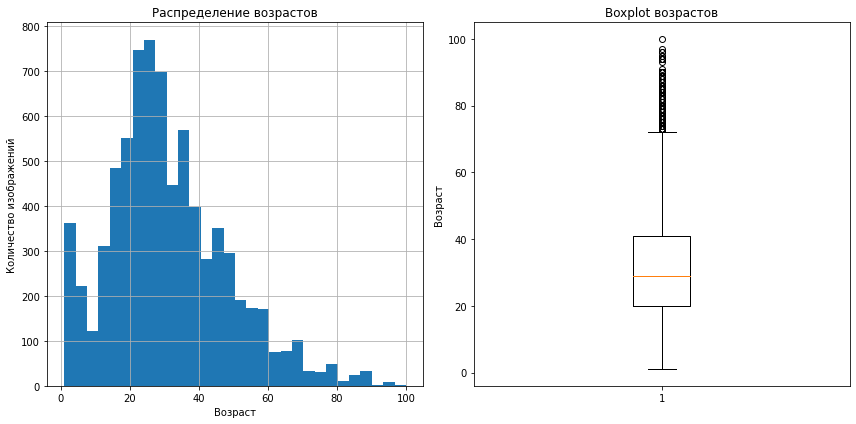

In [6]:
plt.figure(figsize=(12, 6))

# Гистограмма распределения возрастов
plt.subplot(1, 2, 1)
labels['real_age'].hist(bins=30)
plt.title('Распределение возрастов')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')

# Boxplot для возрастов
plt.subplot(1, 2, 2)
plt.boxplot(labels['real_age'])
plt.title('Boxplot возрастов')
plt.ylabel('Возраст')

plt.tight_layout()
plt.show()

1. Большинство покупателей находятся в возрасте от 18 до 40 лет.
2. Распределение можно описать как нормальное со смещением влево.
3. Есть пик около 0 - группа детей (родители ходят в магазин с детьми).
4. Всё что больше 70 боксплот пометил как выбросы. Это самая малочисленная группа покупателей

Установим следующие значения для генератора изображений:
- target_size=(224, 224). Это означает, что все изображения будут изменены до размера 224x224 пикселей. Этот размер часто используется в популярных архитектурах сверточных нейронных сетей, таких как VGG16, ResNet и других. 
- batch_size=32. Это означает, что на каждой итерации обучения модель будет использовать 32 изображения для вычисления градиентов и обновления своих параметров. Размер пакета 32 является компромиссом между использованием памяти и производительностью. 
- class_mode='raw'. Так как мы работаем с задачей регрессии, где нужно предсказать непрерывное значение на основе изображения, использование class_mode='raw' поможет загрузить эти значения без преобразования.

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42)

Found 7591 validated image filenames.


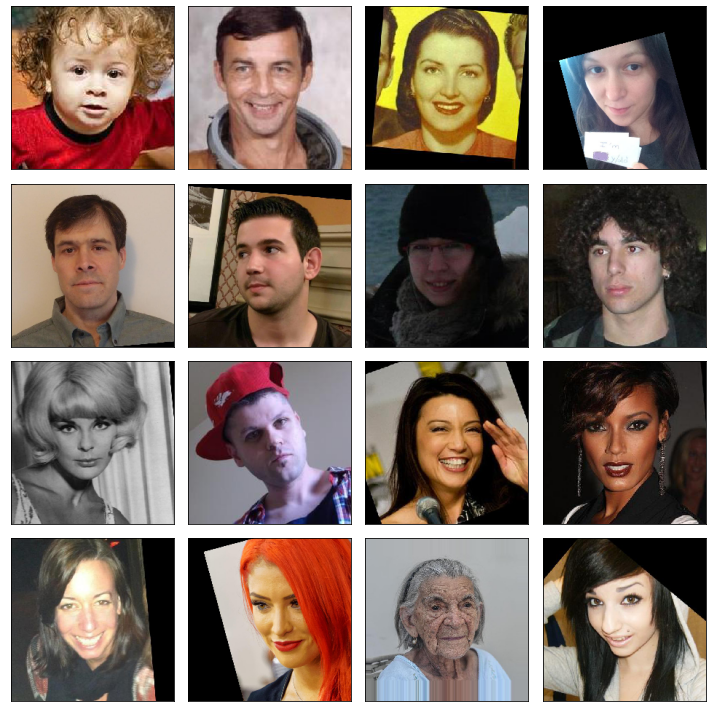

In [8]:
features, target = next(train_gen_flow)

# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

1. Фотографии цветные, есть черно-белые.
2. Встречаются снимки, сделанные под заметным углом
3. На некоторых фотографиях присутствуют посторонние объекты
4. Встречаются экземпляры с наклоном головы, поворот лица под острым углом, нестандартные ракурсы.
5. Некоторые фото темные

Вывод:

1. В датасете 7591 фотографий
2. Пропусков и дубликатов нет.
3. Большинство покупателей находятся в возрасте от 18 до 40 лет, есть пик около 0.
4. Распределение можно описать как нормальное со смещением влево.
4. Всё что больше 70 боксплот пометил как выбросы. Это самая малочисленная группа покупателей. 
5. Особенности набора данных создают определенные сложности для анализа, но в целом сохраняется узнаваемость лиц на большинстве изображений. Наибольшие трудности могут вызывать фото с выраженными артефактами и сильными угловыми искажениями.

## Обучение модели

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPool2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels, 
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow

def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
 
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```python

Train for 178 steps, validate for 119 steps
Epoch 1/10
2025-04-09 07:41:23.648096: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-04-09 07:41:24.175940: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 93s - loss: 253.7157 - mae: 11.3766 - val_loss: 1017.4940 - val_mae: 27.2232
Epoch 2/10
178/178 - 52s - loss: 78.9105 - mae: 6.6247 - val_loss: 894.3003 - val_mae: 25.0481
Epoch 3/10
178/178 - 51s - loss: 50.6452 - mae: 5.3982 - val_loss: 292.2989 - val_mae: 12.8685
Epoch 4/10
178/178 - 49s - loss: 38.1912 - mae: 4.7346 - val_loss: 140.2521 - val_mae: 8.9175
Epoch 5/10
178/178 - 50s - loss: 28.3202 - mae: 4.0159 - val_loss: 80.2402 - val_mae: 6.7278
Epoch 6/10
178/178 - 49s - loss: 21.9934 - mae: 3.6234 - val_loss: 72.5478 - val_mae: 6.3355
Epoch 7/10
178/178 - 50s - loss: 17.8976 - mae: 3.2395 - val_loss: 69.8464 - val_mae: 6.3129
Epoch 8/10
178/178 - 51s - loss: 15.0634 - mae: 2.9757 - val_loss: 67.2004 - val_mae: 6.1057
Epoch 9/10
178/178 - 49s - loss: 11.5872 - mae: 2.6080 - val_loss: 68.2293 - val_mae: 6.1614
Epoch 10/10
178/178 - 49s - loss: 10.4129 - mae: 2.4679 - val_loss: 64.6191 - val_mae: 6.0172
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 12s - loss: 64.6191 - mae: 6.0172
        
```

## Анализ обученной модели

В ходе обучения модели на протяжении 10 эпох наблюдается значительное снижение как значения функции потерь (loss), так и средней абсолютной ошибки (mae) как на обучающем, так и на валидационном наборе данных.

**1. Обучение:** 

   • В первой эпохе значение loss составило 253.7157, а mae — 11.3766. 

   • К десятой эпохе loss уменьшился до 10.4129, а mae — до 2.4679. Это свидетельствует о том, что модель успешно обучается и улучшает свои предсказания.

**2. Валидация:**

   • В первой эпохе valloss равнялось 1017.4940, а valmae — 27.2232.

   • К десятой эпохе valloss снизился до 64.6191, а valmae — до 6.0172. Это также указывает на улучшение качества предсказаний модели на валидационном наборе.

**3. Заключение:**

   • Модель демонстрирует хорошую сходимость, так как наблюдается стабильное уменьшение потерь и ошибок на обоих наборах данных. Однако стоит обратить внимание на возможное переобучение, если разница между обучающей и валидационной ошибками начнет увеличиваться в будущем. Рекомендуется продолжать мониторинг производительности модели и использовать методы регуляризации при необходимости.